Notebook purpose:

- Validate current account balances

Approach:

1. Identify od fee txns
2. For each user-month, create dummies indicating whether was in overdraft and paid od fees
3. Explore relationship between above dummies

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [21]:
def keep_current_accounts(df):
    return df[df.account_type.isin(['current'])]

def tag_od_txns(df):
    """Tags overdraft fee payments."""
    pattern = r'\b(?:od|o d|overdraft|o draft)\b.*(?:fee|usage|interest)'
    is_od_fee_txn = df.desc.str.contains(pattern) & df.debit
    df['od_fee_txn'] = is_od_fee_txn
    return df

SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = (aws.read_parquet(fp)
      .pipe(keep_current_accounts)
      .pipe(tag_od_txns))


print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))
df.head(1)

Rows: 554,055
Users: 215


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,desc_old,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,savings,od_fee_txn
0,688261,2012-01-03,777,400.0,mdbremoved,NaN,transfers,transfers,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,<mdbremoved> - s/o,364.220001,non merchant mbl,transfers,other account,other account,u,201201,-1542.99646,24319.220881,False,False


## Identify overdraft fee txns

Approach: inspect txn descriptions for relevant tags and note down od-related ones, then inspect common tags for these od-descriptions, then check for additional od-related txns in these tags. Based on that, design regex pattern and gauge precision and recall. 

Hypothesised pattern based on data inspection (omits word boundary for second group as there are txns descriptions where *interest* is part of a larger words like *interestto*).

In [9]:
pattern = r'\b(?:od|o d|overdraft|o draft)\b.*(?:fee|usage|interest)'
mask = df.desc.str.contains(pattern) & df.debit

Matches only txns with relevant tags

In [10]:
od_fees = df[mask]
tag_counts = od_fees.tag_auto.value_counts()
tag_counts[:5]

bank charges        9386
interest charges     173
interest income      137
banking charges       95
accessories            0
Name: tag_auto, dtype: int64

Has high precision (i.e. very few -- no? -- false positives)

In [11]:
od_fees.desc.sample(n=10)

39032                                                           daily od fee chg
98628                                                           daily od fee chg
147607                   arranged overdraft interest arranged overdraft interest
638895                                                        daily od fee 07 09
479997                                                              daily od fee
635841                                                        daily od fee 19 05
622128                                                              daily od fee
352993                                            overdraft interest to 24dec 18
52223     arranged od usage arranged od usage 15may a c 0688 type charges charge
635607                                                              daily od fee
Name: desc, dtype: object

Seems to have high recall (i.e. finds most od-related txns). Below shows that using a less restrictive pattern has no more true positives but a few false positives (being yet less restrictive and omitting word boundary around first group finds thousandas of irrelevant txns, like `desc`s containing *food*, and finds only a handful of addition bank charges txns).

In [12]:
pattern_alt = r'\b(?:od|o d|overdraft|o draft)\b'
mask_alt = df.desc.str.contains(pattern_alt) & df.debit
df[mask_alt].tag_auto.value_counts()[:9]

bank charges                9643
interest charges             173
interest income              137
banking charges               95
enjoyment                      2
cash                           1
tv / movies package            1
entertainment, tv, media       1
paypal account                 0
Name: tag_auto, dtype: int64

In [13]:
mask_alt = df.desc.str.contains(pattern_alt) & df.debit & df.tag_auto.str.contains('enjoyment|cash|tv')
df[mask_alt].desc

117905                                                    paypal c o d e x cd 7038 deb
426340                       visa cash withdrawal trg od oruzja eur 30 00000 at 1 1274
442285                                    amzn mktp uk od 0us luxembourg on 12 jan bcc
485168    card payment to kindle svcs od 3553gv 5 3 99 gbp rate 1 00 gbp on 20 01 2020
525398                               3395 24jan 20 prime video od 8k67ny 5 353 7661 lu
Name: desc, dtype: object

## Dated od fees

Extract dates for which od fees are being charged to check whether account was in overdraft on these days (or the last preceeding date for which we observe any txns).

We are looking for txns with these kinds of `desc`s:

In [369]:
df[df.desc.str.contains('daily od fee \d\d')].desc.head()

38173    daily od fee 11 08 chg
38203    daily od fee 19 08 chg
38204    daily od fee 18 08 chg
38345    daily od fee 15 09 chg
38346    daily od fee 16 09 chg
Name: desc, dtype: object

In [354]:
def get_od_dates(df):
    pattern = r'daily od fee (?P<day>\d\d) (?P<month>\d\d)'
    return (df.set_index(['date', 'account_id'])
            .desc.str.extract(pattern)
            .dropna()
            .reset_index()
            .assign(year=lambda df: df.date.dt.year)
            .assign(date=lambda df: pd.to_datetime(df[['year', 'month', 'day']]))
            .loc[:, ['account_id', 'date']])

od_dates = get_od_dates(df)
od_dates.head()

,account_id,date
0,152138,2018-08-11
1,152138,2018-08-19
2,152138,2018-08-18
3,152138,2018-09-15
4,152138,2018-09-16


In [359]:
def get_od_dates_balances(od_dates, df):
    balances = (df.set_index('date')
                .groupby('account_id')
                .resample('d').balance.first().ffill()
                .reset_index())
    return od_dates.merge(balances)
    
od_dates_balances = get_od_dates_balances(od_dates, df)
od_dates_balances.head()

,account_id,date,balance
0,152138,2018-08-11,-443.612732
1,152138,2018-08-19,-601.192749
2,152138,2018-08-18,-601.192749
3,152138,2018-09-15,-625.332764
4,152138,2018-09-16,-625.332764


In [375]:
obs = len(od_dates_balances)
in_od = k.balance.lt(0).sum()
print(f'Accounts are in overdraft on {in_od} of {obs} dates ({in_od / obs:.1%}) for which od fees are being charged.')

Accounts are in overdraft on 2490 of 2577 dates (96.6%) for which od fees are being charged.


### Monthly overdrafts and od fee payments

We check for correlation between a account having been in overdraft and been charged od fees anytime during the month.

The correlation between these two events is low. Possibly because od fees are not always charged with calendar months (e.g. sometimes planned overdrafts are charged mid month for a 30-day period ending towards the end of the previosu month)

In [387]:
df.loc[22759:22759, ['date', 'amount', 'desc']]

,date,amount,desc
22759,2014-05-16,0.31,overdraft interest to 24apr 2014


### Create dummies for in overdraft and paid od fee

For each user-month, create a dummies indicating whether the user's current account was in overdraft and whether they paid overdraft fees.

In [377]:
def make_overdraft_data(df):
    mask = df.account_type.eq('current')
    cols = ['user_id', 'date', 'balance', 'od_fee_txn']
    month = pd.Grouper(key='date', freq='M')    
    od_fee_paid = lambda s: s.max() == 1
    in_od = lambda s: s.min() < 0
    
    return (df.loc[mask, cols]
            .groupby(['user_id', month])
            .agg(od_fee_paid=('od_fee_txn', od_fee_paid),
                 in_od=('balance', in_od))
            .groupby('user_id')
            .resample('M', level='date').first()
            .fillna(0).astype(bool))

od = make_overdraft_data(df)
od.head(2)

od_fee_paid  in_od
user_id date                          
777     2012-01-31        False   True
        2012-02-29        False   True

### Relationship between od fees paid this month and in od this month

In [378]:
def fee_od_matrix(od_data, in_od_col='in_od'):
    """Print confusion matrix for od_fee_paid and in_od columns."""
    m = (od_data.groupby(['od_fee_paid', in_od_col]).size()
         .reset_index()
         .pivot(in_od_col, 'od_fee_paid')
         .droplevel(level=0, axis=1))
    
    correct = np.diag(m).sum()
    share_correct = correct / m.sum().sum()
    print(f'Total (and share) correct: {correct} ({share_correct:.1%})')
    return m

fee_od_matrix(od)

Total (and share) correct: 3757 (57.7%)


od_fee_paid,False,True
in_od,,
False,2506,116
True,2638,1251


### Relationship between od fees paid this month and od this or previous month

In [379]:
od['in_od2'] = np.maximum(od.in_od, od.in_od.shift()) == 1
od[18:21]

od_fee_paid  in_od  in_od2
user_id date                                  
777     2013-07-31        False   True    True
        2013-08-31        False  False    True
        2013-09-30        False  False   False

In [380]:
fee_od_matrix(od, in_od_col='in_od2')

Total (and share) correct: 3448 (53.0%)


od_fee_paid,False,True
in_od2,,
False,2152,71
True,2992,1296


## Case studies

Look into missing balances data
- All balances missing is okay
- But there shouldn't be missing balances if there are any nonmissing ones

Case studies: 
- Expected pattern: ['1652258']
- Unexpected pattern:

In [111]:
def draw_account_sample(df, n=1, seed=2312):
    """Random sample of accounts withcharges."""
    rng = np.random.default_rng(seed=seed)
    accounts = df[df.od_fee_txn].account_id.unique()
    return rng.choice(accounts, size=n)

def make_account_data(df, account_id):
    df = df.copy()
    data = df[df.account_id == account_id]
    return (data.groupby(['date', 'account_id'])
            .agg({'balance': 'first', 'od_fee_txn': 'max'})
            .reset_index(level='account_id'))

def make_balance_od_fee_plot(df):
    title = f'Account id: {df.account_id[0]}'
    df.balance.plot(title=title)
    plt.axhline(0, color='orange', linewidth=2)
    d = df[df.od_fee_txn]
    d.od_fee_txn.astype(int).plot(marker='o', markersize=3, secondary_y=True, linewidth=0, color='green')


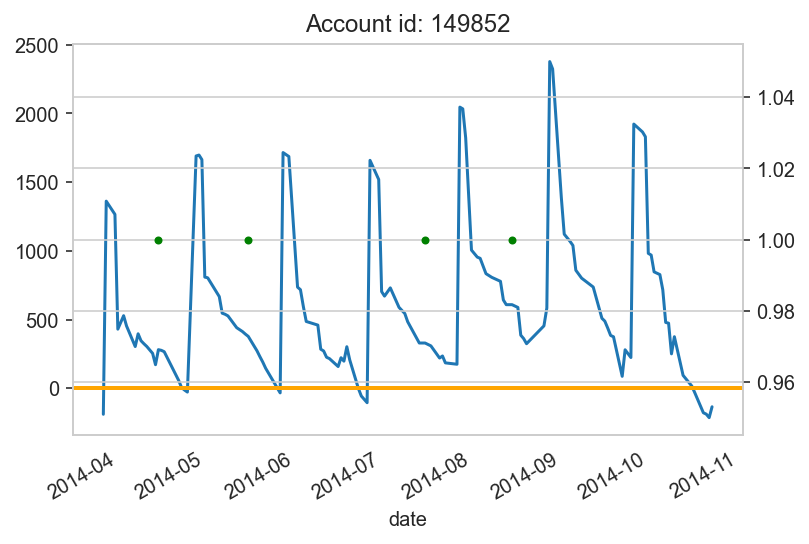

In [112]:
for user in draw_account_sample(df, n=1, seed=None):
    data = make_account_data(df, user)
    make_balance_od_fee_plot(data)

In [113]:
def make_explore_account_data(plot_data):
    account_id = plot_data.account_id[0]
#     cols = ['date', 'user_id', 'amount', 'desc', 'account_provider', 'od_fee_txn', 'balance']
    mask = df.account_id.eq(account_id) & df.od_fee_txn
    return df.loc[mask]

dfu = make_explore_account_data(data)
dfu

,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,desc_old,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,savings,od_fee_txn
22700,23897490,2014-04-15,76777,0.72,overdraft interest,NaN,spend,finance,False,sg2 7,2014-06-25,NaN,1981.0,2014-06-25,149852,2015-01-03 12:26:00,hsbc,current,2014-06-30,2017-08-13,True,overdraft interest,-134.0,personal,interest charges,NaN,interest charges,u,201404,281.229858,21267.736607,False,True
22759,23897548,2014-05-16,76777,0.31,overdraft interest to 24apr 2014,NaN,spend,finance,False,sg2 7,2014-06-25,NaN,1981.0,2014-06-25,149852,2015-01-03 12:26:00,hsbc,current,2014-06-30,2017-08-13,True,overdraft interest to 24apr2014,-134.0,account provider,interest charges,NaN,interest charges,u,201405,377.739868,21267.736607,False,True
22869,32503854,2014-07-16,76777,0.10,overdraft interest,NaN,spend,finance,False,sg2 7,2014-06-25,NaN,1981.0,2014-06-25,149852,2015-01-03 12:26:00,hsbc,current,2014-08-27,2017-08-13,True,overdraft interest,-134.0,personal,interest charges,NaN,interest charges,u,201407,329.600006,21267.736607,False,True
22911,32503896,2014-08-15,76777,0.12,overdraft interest to 24jul 2014,NaN,spend,finance,False,sg2 7,2014-06-25,NaN,1981.0,2014-06-25,149852,2015-01-03 12:26:00,hsbc,current,2014-08-27,2017-08-13,True,overdraft interest to 24jul2014,-134.0,account provider,interest charges,NaN,interest charges,u,201408,608.580017,21267.736607,False,True
